# Model Evaluation

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

## Import Data

In [2]:
X_val = pd.read_hdf("data/classifier/test.h5", key="X")
y_val = pd.read_hdf("data/classifier/test.h5", key="y").values

In [3]:
# Remove samples and weights from X_val
val_samples = X_val["Sample"].values
val_weights = X_val["gen_weights"].values
X_val.drop(["Sample", "gen_weights"], axis=1, inplace=True)

## Import model

In [4]:
def load_model(study_df, best=True, name=None):
    """
    Automatically loads model of a specified optuna study
    
    study_df -> pandas dataframe: study dataframe
    best -> bool: select best model of study
    name -> string: model name to load. Gets overwritten by input best.
    
    return -> keras model
    """
    
    if best: name = "trial_" + str(study_df["val_acc"].argmax())
    model = keras.models.load_model("models/" + name + ".h5")
    print("Best Model:", name)
        
    return model

In [5]:
name, best = "trial_18", True
study_df = pd.read_hdf("optuna_studies/study_1.h5", key="study")

model = load_model(study_df, best, name)

Best Model: trial_6


# Metrics 

In [6]:
y_preds = model.predict(X_val).reshape(-1)

In [7]:
print("Model Accuracy:", accuracy_score(y_preds.round(), y_val))

Model Accuracy: 0.862170704478564


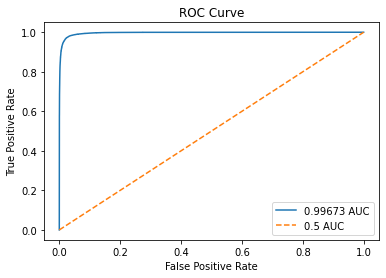

In [8]:
fpr, tpr, thr = roc_curve(y_val, y_preds, sample_weight=val_weights)

roc_auc = roc_auc_score(y_val, y_preds, sample_weight=val_weights)
plt.title("ROC Curve")
plt.plot(fpr, tpr, label=f"{roc_auc:.5f} AUC")
plt.plot([0, 1], [0, 1], "--", label="0.5 AUC")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

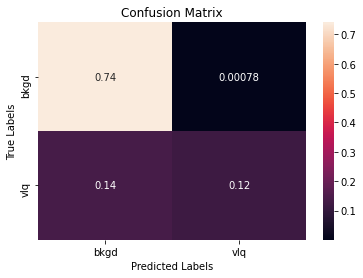

In [9]:
cm = confusion_matrix(y_val, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

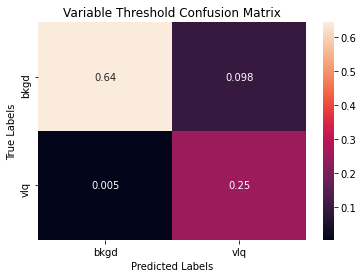

In [10]:
# Get optimal threshold and predictions
optim_thr = thr[np.argmax(tpr - fpr)]
y_preds[y_preds <= optim_thr] = 0
y_preds[y_preds > optim_thr] = 1

# Get confusion matrix
cm = confusion_matrix(y_val, y_preds, normalize="all")

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Variable Threshold Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

# Predicted vs True distributions

## Bkgd Pred vs True

Plotting: 100%|██████████| 69/69 [01:13<00:00,  1.06s/it]


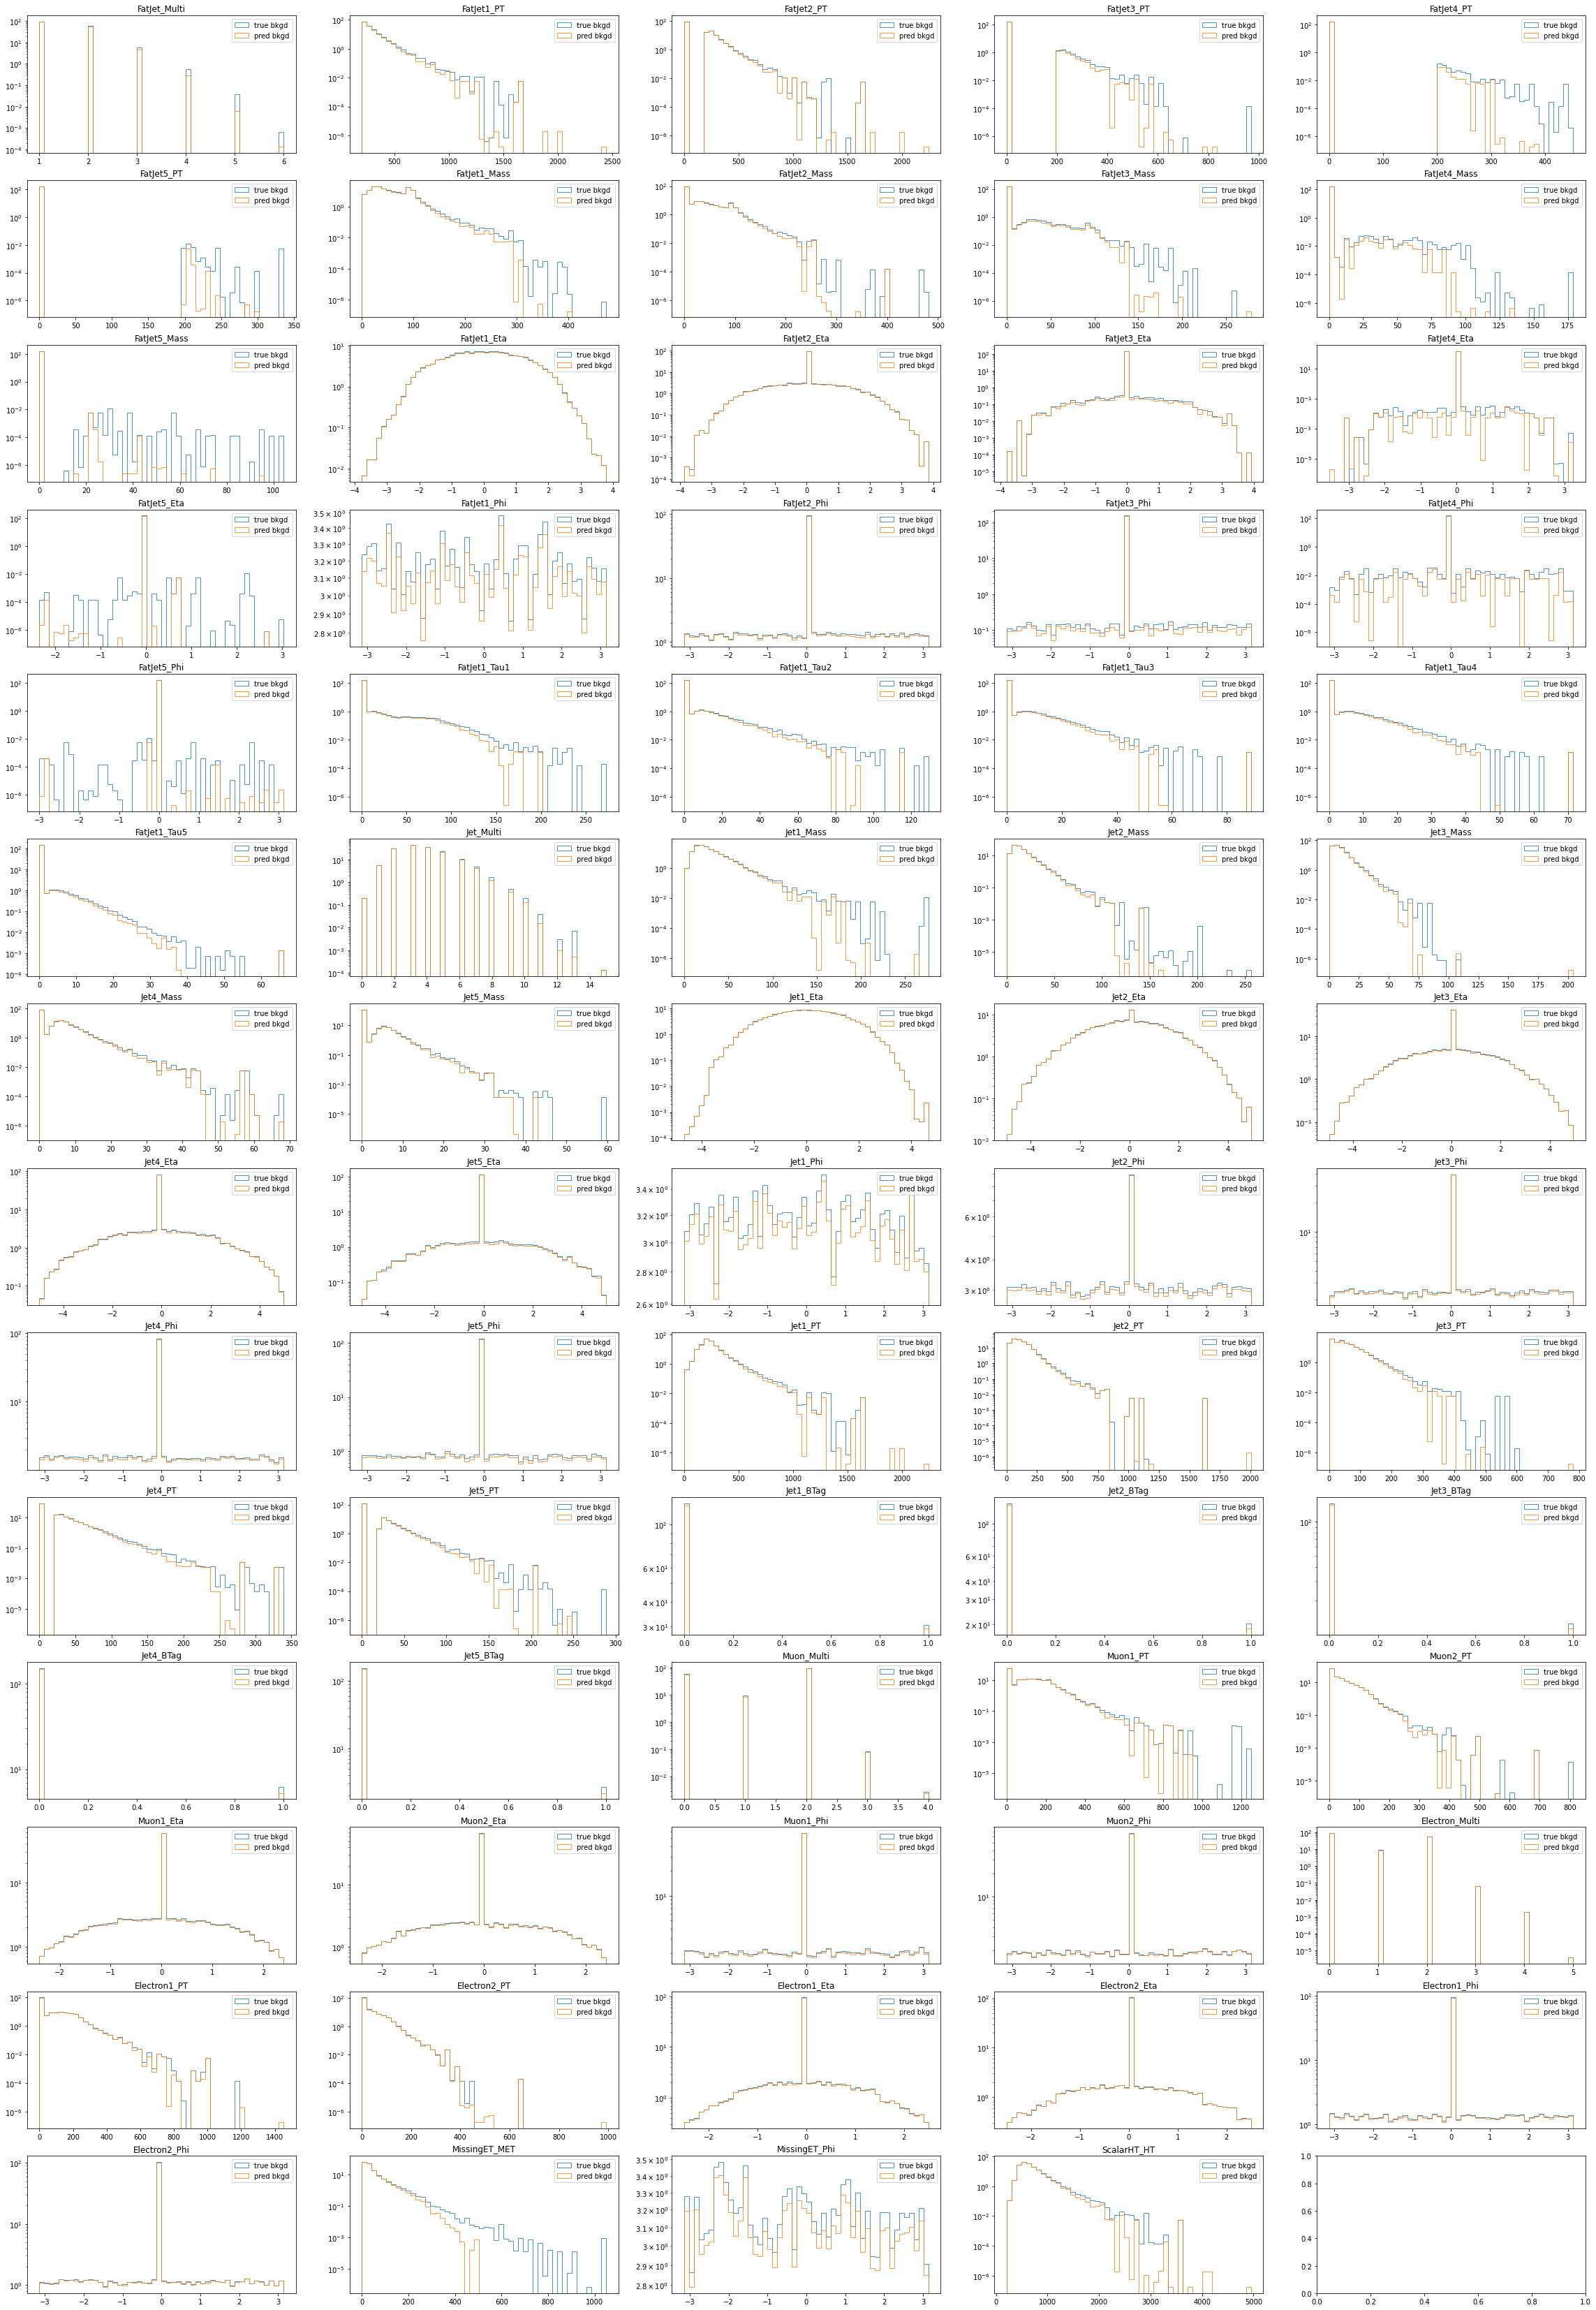

In [11]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(X_val.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
for i, column in tqdm(enumerate(X_val.columns), total=len(list(X_val.columns)), desc="Plotting"):
        # Define histogram range
        hist_min = min(X_val[y_val == 0][column].min(), X_val[y_preds == 0][column].min())
        hist_max = max(X_val[y_val == 0][column].max(), X_val[y_preds == 0][column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(X_val.columns[i])
        axs[row, col].hist(X_val[y_val == 0][column], bins=50, label="true bkgd", alpha=0.8, range=hist_range,
                           weights=val_weights[y_val == 0], histtype='step')
        axs[row, col].hist(X_val[y_preds == 0][column], bins=50, label="pred bkgd", alpha=0.8, range=hist_range,
                           weights=val_weights[y_preds == 0], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/True_vs_Pred_BKGD_distributions.png", dpi=500)
plt.show()

## VLQ Pred vs True

Plotting: 100%|██████████| 69/69 [00:34<00:00,  1.99it/s]


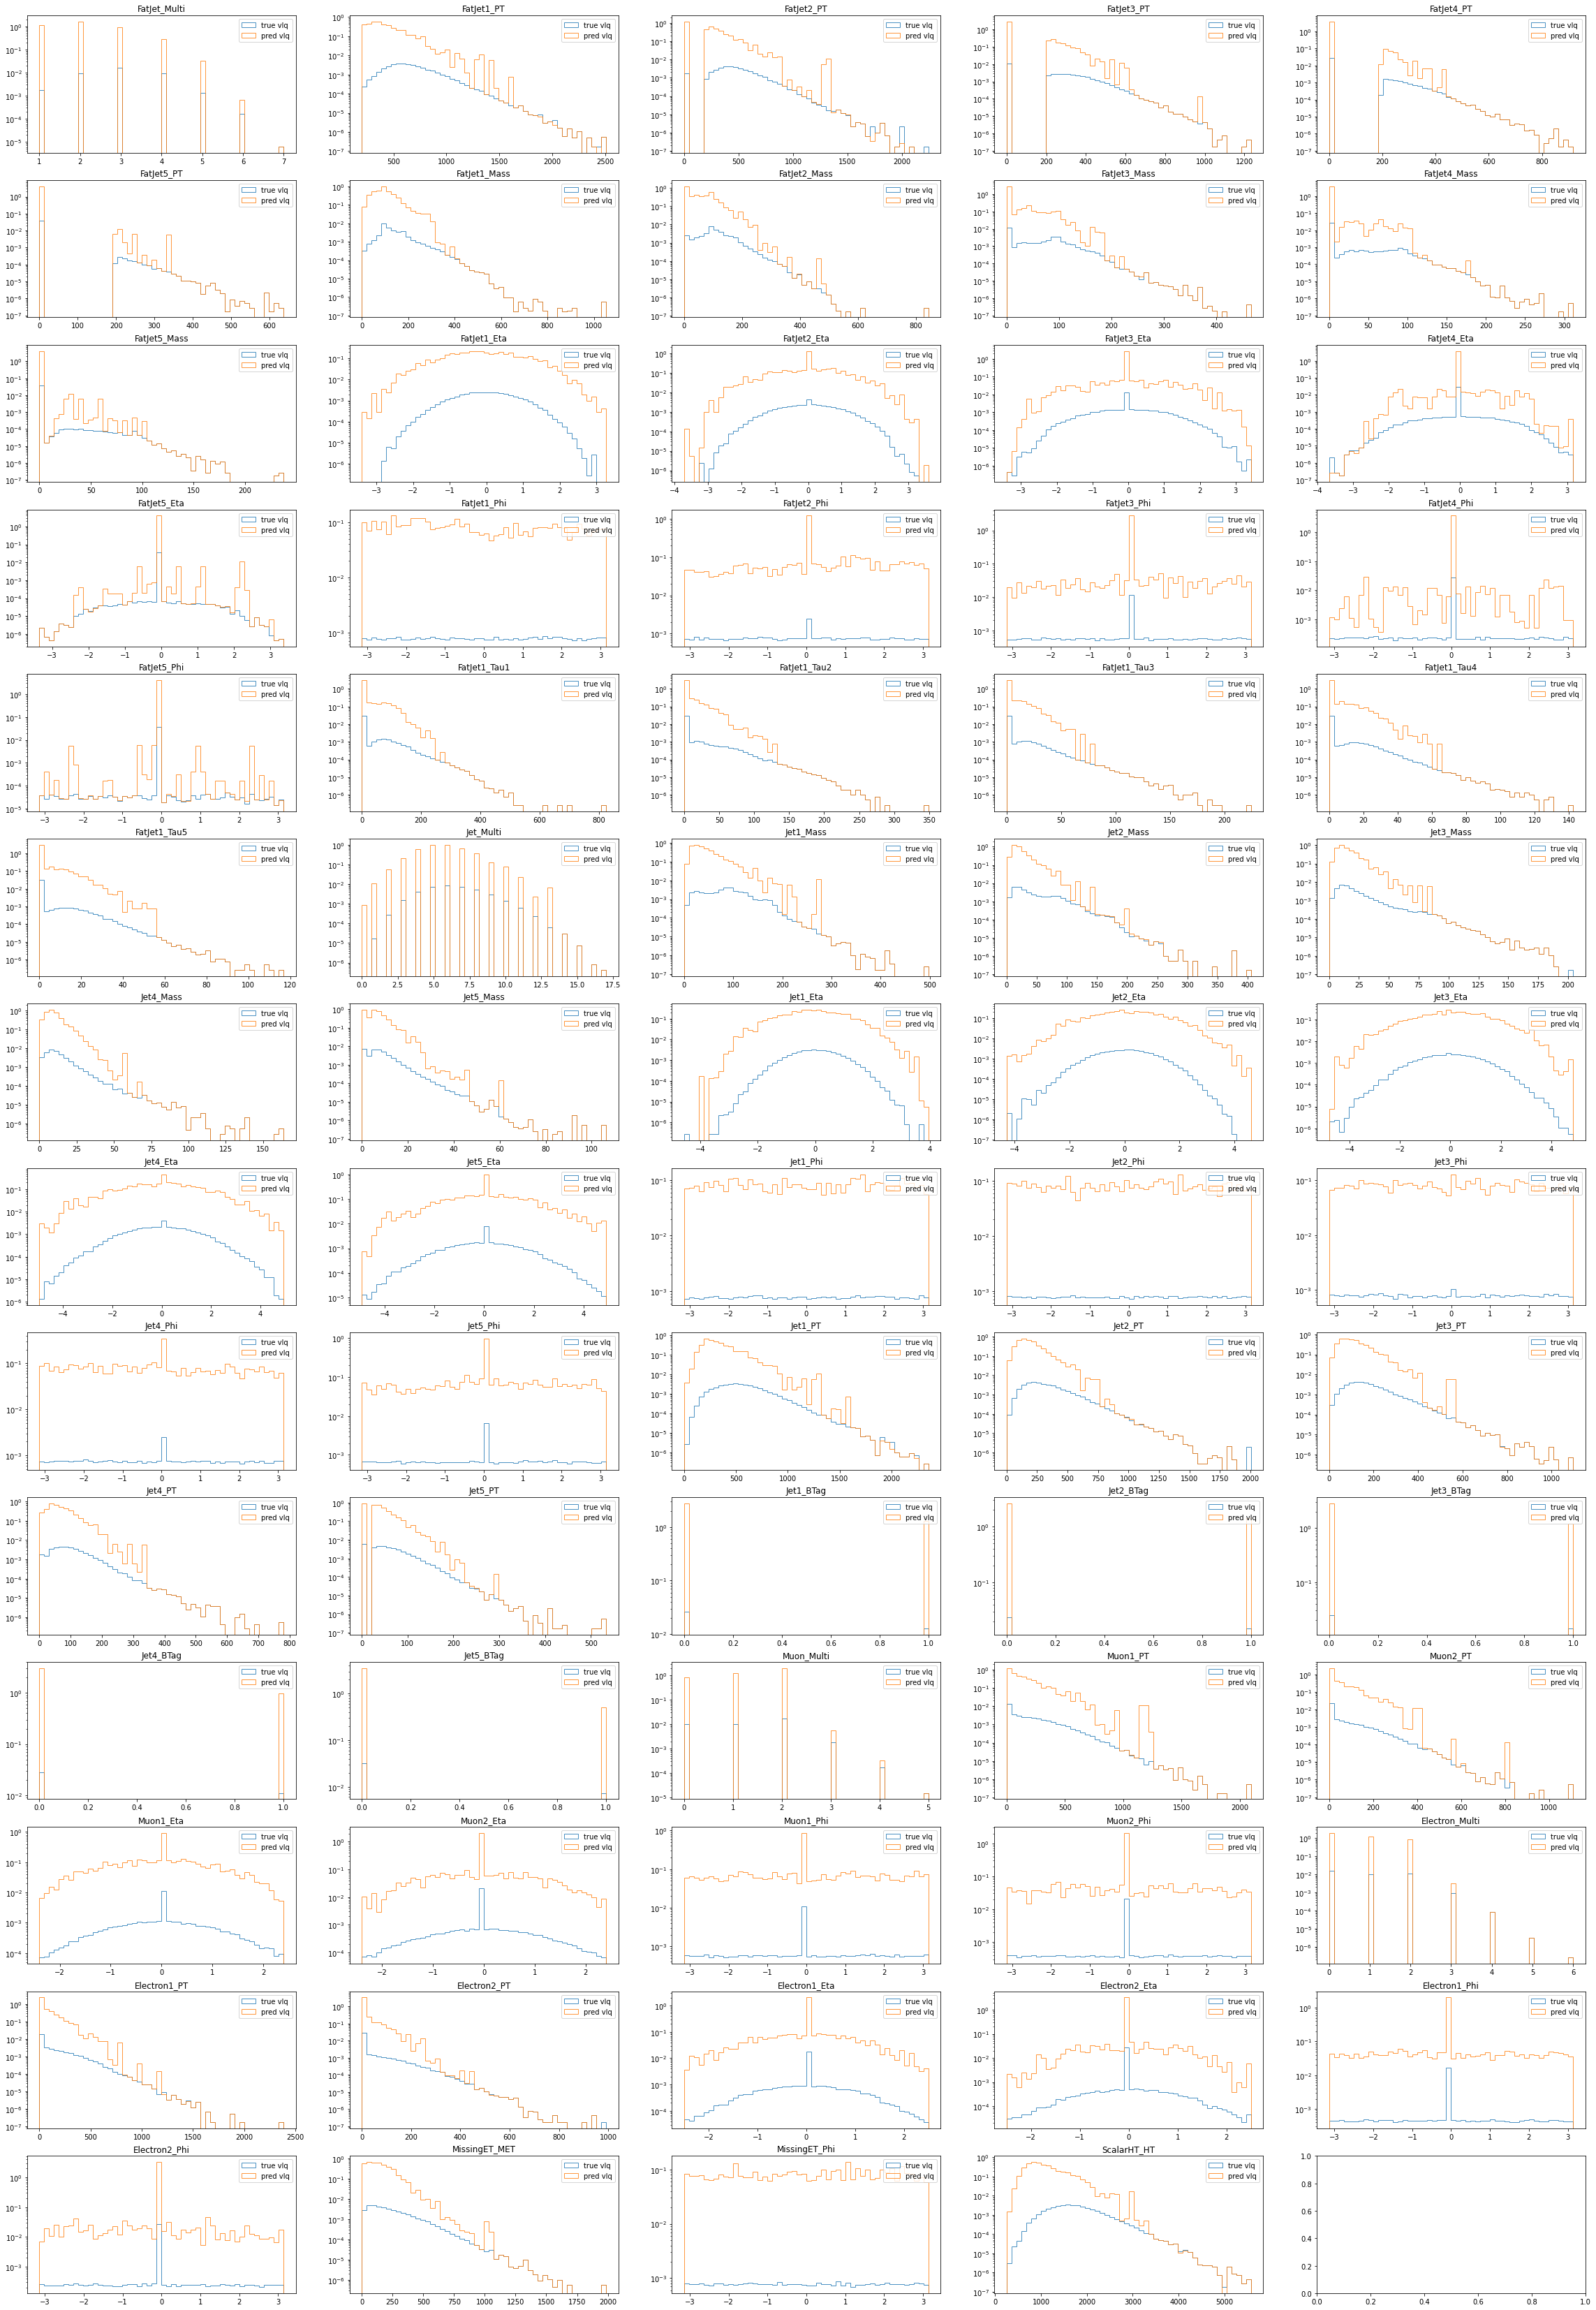

In [12]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(X_val.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
for i, column in tqdm(enumerate(X_val.columns), total=len(list(X_val.columns)), desc="Plotting"):
        # Define histogram range
        hist_min = min(X_val[y_val == 1][column].min(), X_val[y_preds == 1][column].min())
        hist_max = max(X_val[y_val == 1][column].max(), X_val[y_preds == 1][column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(X_val.columns[i])
        axs[row, col].hist(X_val[y_val == 1][column], bins=50, label="true vlq", alpha=0.8, range=hist_range,
                           weights=val_weights[y_val == 1], histtype='step')
        axs[row, col].hist(X_val[y_preds == 1][column], bins=50, label="pred vlq", alpha=0.8, range=hist_range,
                           weights=val_weights[y_preds == 1], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/True_vs_Pred_VLQ_distributions.png", dpi=500)
plt.show()

# MCDropout

In [13]:
num_models = 100
mcpreds = []

for _ in tqdm(range(num_models), total=num_models, desc="MCDropout"):
    mcpreds.append(model.predict(X_val))
    
mcpreds = np.array(mcpreds)

MCDropout: 100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


In [14]:
mc_means = mcpreds.mean(axis=0)
mc_stds = mcpreds.std(axis=0)

In [15]:
print("MCDropout Accuracy:", accuracy_score(mc_means.round(), y_val))

MCDropout Accuracy: 0.8632508372841546


MCDropout AUC Score: 0.9969188901390673


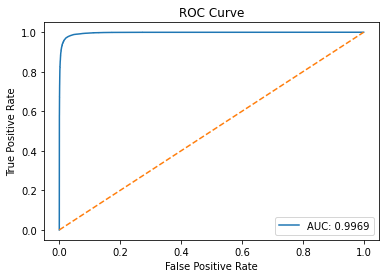

In [16]:
fpr, tpr, thr = roc_curve(y_val, mc_means, sample_weight=val_weights)

print("MCDropout AUC Score:", roc_auc_score(y_val, mc_means, sample_weight=val_weights))
plt.title("ROC Curve")
plt.plot(fpr, tpr, label=f"AUC: {roc_auc_score(y_val, mc_means, sample_weight=val_weights):.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("plots/ROC_MCDropout.png", dpi=300)
plt.show()

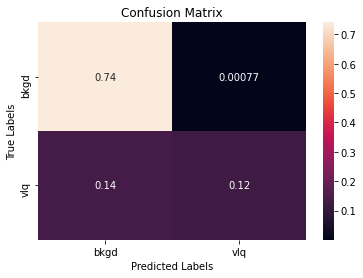

In [17]:
cm = confusion_matrix(y_val, mc_means.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

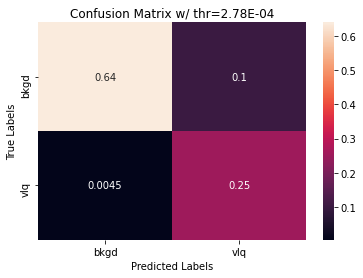

In [18]:
# Get best threshold and predictions
mc_thr = thr[np.argmax(tpr - fpr)]
mc_preds = mc_means.copy()
mc_preds[mc_preds <= mc_thr] = 0
mc_preds[mc_preds > mc_thr] = 1

# Calculate confusion matrix
cm = confusion_matrix(y_val, mc_preds, normalize="all")

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title(f"Confusion Matrix w/ thr={mc_thr:.2E}")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.savefig("plots/MCDropout_CM.png", dpi=300)
plt.show()

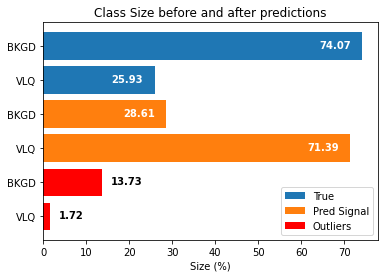

In [30]:
fig, ax = plt.subplots()

# Data for bars plot
classes = ("BKGD", "VLQ", "BKGD", "VLQ", "BKGD", "VLQ")
vlq_bar, pred_vlq_bar = 74.07, cm[1][1] / (cm[1][1] + cm[0][1]) * 100
values, pred_values = (vlq_bar, 100-vlq_bar), (100 - pred_vlq_bar, pred_vlq_bar)
l_vlq = (cm[0][1] / (cm[0][0] + cm[0][1]) * 100, cm[1][0] / (cm[1][0] + cm[1][1]) * 100)

# Create plot
ax.set_title("Class Size before and after predictions")
ax.barh([0, 1], values, align="center", label="True")
for x, y in zip(values, [0, 1]):
    ax.text(x - 10, y + 0.06, f"{x:.2f}", color="white", fontweight="bold")
ax.barh([2, 3], pred_values, align="center", label="Pred Signal")
for x, y in zip(pred_values, [2, 3]):
    ax.text(x - 10, y + 0.06, f"{x:.2f}", color="white", fontweight="bold")
ax.barh([4, 5], l_vlq, align="center", label="Outliers", color="red")
for x, y in zip(l_vlq, [4, 5]):
    ax.text(x + 2, y + 0.06, f"{x:.2f}", color="black", fontweight="bold")
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels(classes)
ax.invert_yaxis() # labels from top to bottom
ax.set_xlabel("Size (%)")
ax.legend()

plt.savefig("plots/cut_preds_ratios.png", dpi=200)
plt.show()

# MCDropout Distributions

## VLQ True vs Pred

In [20]:
mc_means = mc_means.reshape(-1)

Plotting: 100%|██████████| 69/69 [00:22<00:00,  3.12it/s]


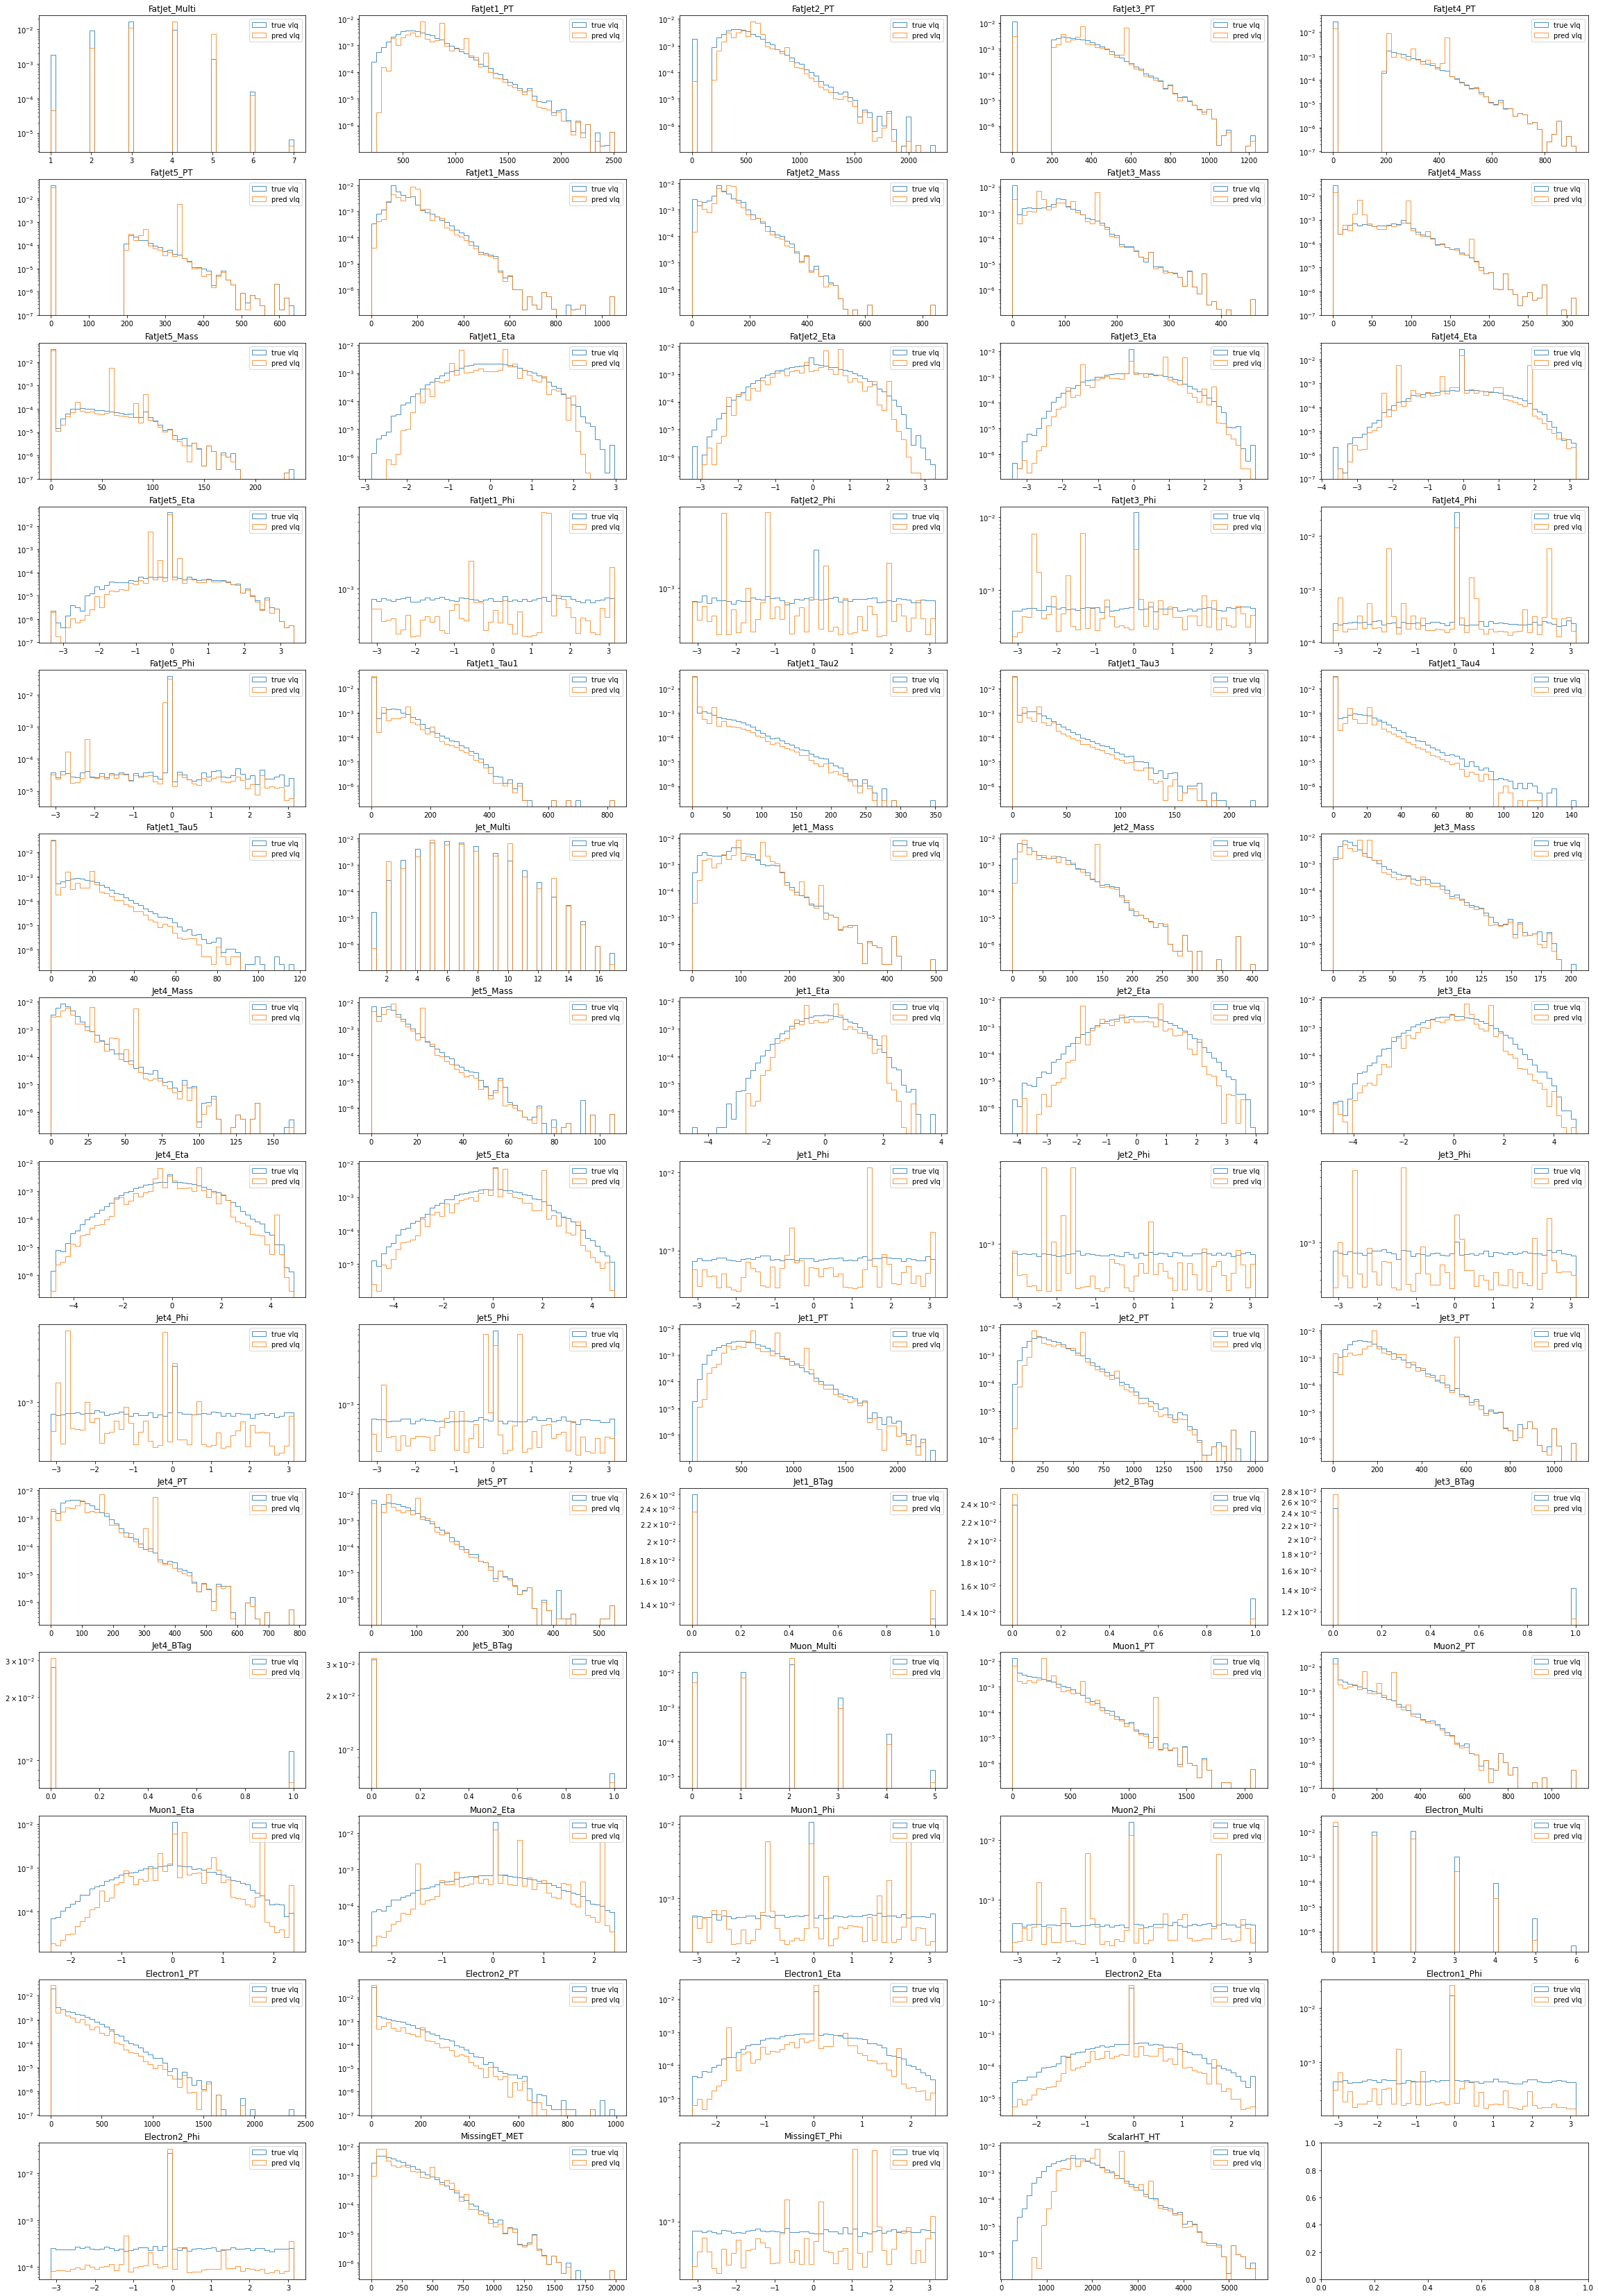

In [21]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(X_val.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
for i, column in tqdm(enumerate(X_val.columns), total=len(list(X_val.columns)), desc="Plotting"):
        # Define histogram range
        hist_min = min(X_val[y_val == 1][column].min(), X_val[mc_means.round() == 1][column].min())
        hist_max = max(X_val[y_val == 1][column].max(), X_val[mc_means.round() == 1][column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(X_val.columns[i])
        axs[row, col].hist(X_val[y_val == 1][column], bins=50, label="true vlq", alpha=0.8, range=hist_range,
                           weights=val_weights[y_val == 1], histtype='step')
        axs[row, col].hist(X_val[mc_means.round() == 1][column], bins=50, label="pred vlq", alpha=0.8, range=hist_range,
                           weights=val_weights[mc_means.round() == 1], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/True_vs_Pred_VLQ_MC_distributions.png", dpi=500)
plt.show()

## BKGD True vs Pred

Plotting: 100%|██████████| 69/69 [01:23<00:00,  1.22s/it]


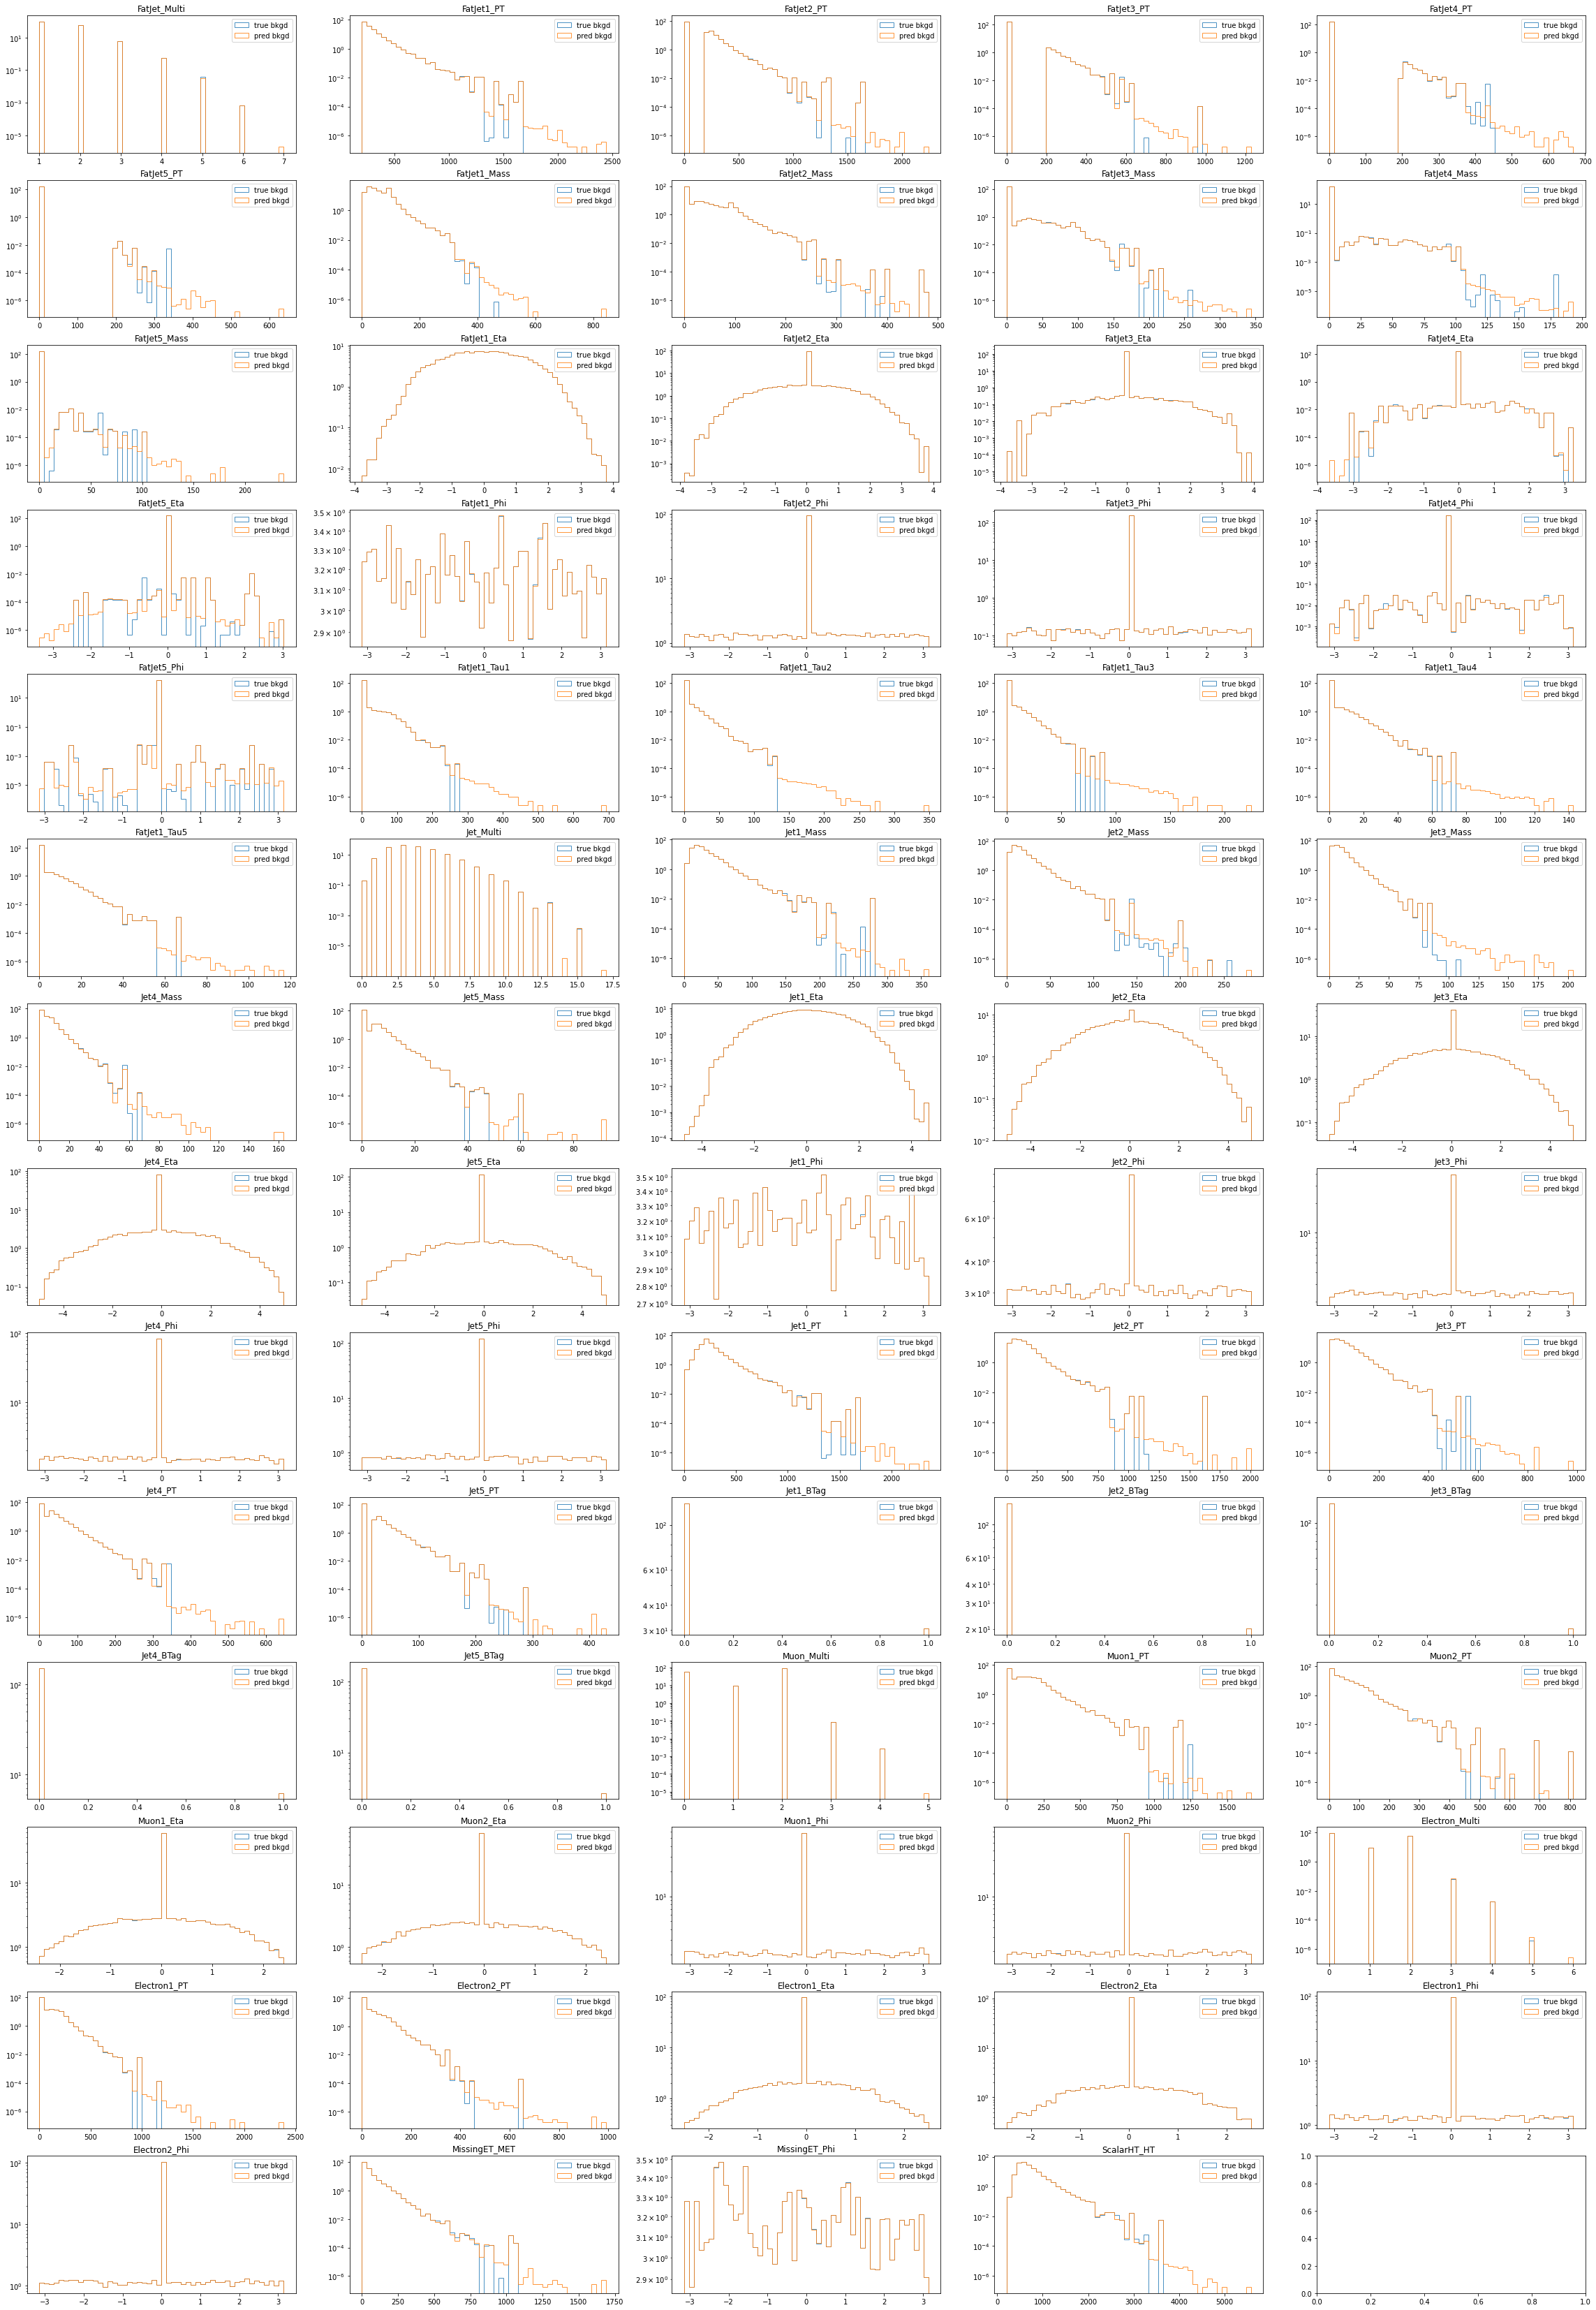

In [22]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(X_val.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
for i, column in tqdm(enumerate(X_val.columns), total=len(list(X_val.columns)), desc="Plotting"):
        # Define histogram range
        hist_min = min(X_val[y_val == 0][column].min(), X_val[mc_means.round() == 0][column].min())
        hist_max = max(X_val[y_val == 0][column].max(), X_val[mc_means.round() == 0][column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(X_val.columns[i])
        axs[row, col].hist(X_val[y_val == 0][column], bins=50, label="true bkgd", alpha=0.8, range=hist_range,
                           weights=val_weights[y_val == 0], histtype='step')
        axs[row, col].hist(X_val[mc_means.round() == 0][column], bins=50, label="pred bkgd", alpha=0.8, range=hist_range,
                           weights=val_weights[mc_means.round() == 0], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/True_vs_Pred_BKGD_MC_distributions.png", dpi=500)
plt.show()

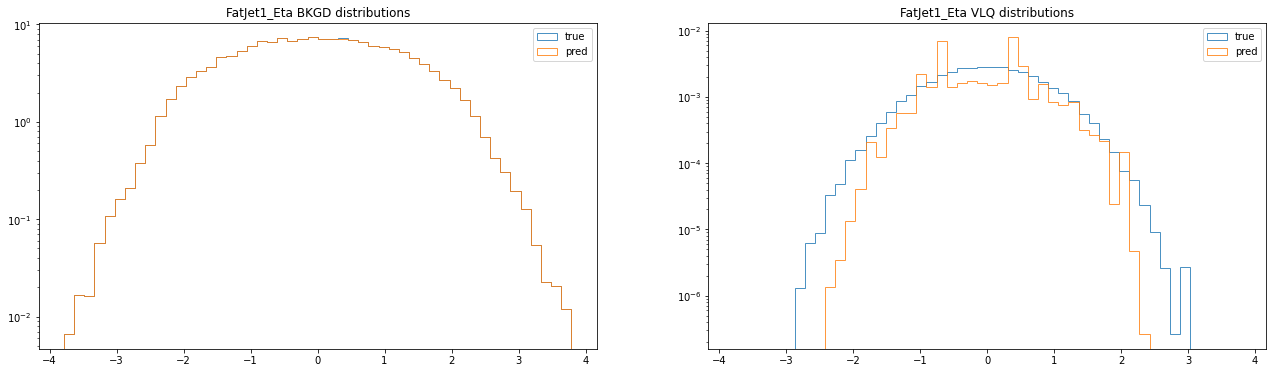

In [23]:
# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
bins, column = 50, "FatJet1_Eta"

# Define histogram range
hist_min = min(X_val[y_val == 0][column].min(), X_val[mc_means.round() == 0][column].min())
hist_max = max(X_val[y_val == 0][column].max(), X_val[mc_means.round() == 0][column].max())
hist_range = (hist_min, hist_max)

# Plot data
ax1.set_title(f"{column} BKGD distributions")
ax1.hist(X_val[y_val == 0][column], bins=50, label="true", alpha=0.8, range=hist_range,
        weights=val_weights[y_val == 0], histtype='step')
ax1.hist(X_val[mc_means.round() == 0][column], bins=50, label="pred", alpha=0.8, range=hist_range,
        weights=val_weights[mc_means.round() == 0], histtype='step')
ax2.set_title(f"{column} VLQ distributions")
ax2.hist(X_val[y_val == 1][column], bins=50, label="true", alpha=0.8, range=hist_range,
        weights=val_weights[y_val == 1], histtype='step')
ax2.hist(X_val[mc_means.round() == 1][column], bins=50, label="pred", alpha=0.8, range=hist_range,
        weights=val_weights[mc_means.round() == 1], histtype='step')
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.legend()
ax2.legend()

plt.savefig("plots/MCDropout_Distributions.png", dpi=400)
plt.show()

# MCDropout STDs by class

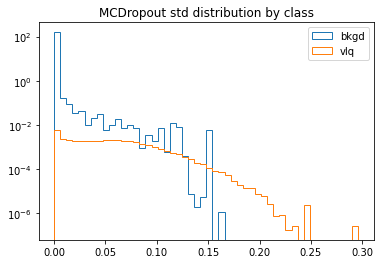

In [24]:
hist_min = min(mc_stds[y_val == 0].min(), mc_stds[y_val == 1].min())
hist_max = max(mc_stds[y_val == 0].max(), mc_stds[y_val == 1].max())
hist_range = (hist_min, hist_max)

plt.title("MCDropout std distribution by class")
plt.hist(mc_stds[y_val == 0], label="bkgd", bins=50, range=hist_range, histtype="step", weights=val_weights[y_val == 0])
plt.hist(mc_stds[y_val == 1], label="vlq", bins=50, range=hist_range, histtype="step", weights=val_weights[y_val == 1])
plt.yscale("log")
plt.legend()
plt.savefig("plots/mcdropout_std_distribution_by_class.png", dpi=200)
plt.show()

# MCDropout STDs by sample

In [25]:
# Gather bkgd samples
bkgd_samples = glob("data/dileptonic/*.csv")
bkgd_samples = [sample.split("/")[-1].split(".")[0] + "_BKGD" for sample in bkgd_samples]

# Gather VLQ samples
vlq_samples = glob("data/sm_gluon_vlq/*.csv")
vlq_samples = [sample.split("/")[-1].split(".")[0] + "_VLQ" for sample in vlq_samples]

# Concatenate
samples = bkgd_samples + vlq_samples

In [26]:
# Remove test and train from sample names
for i, sample in enumerate(samples):
    if "test" in sample: samples[i] = samples[i].replace("_test", "")
    elif "train" in sample: samples[i] = samples[i].replace("_train", "")

# Remove duplicates
samples = list(dict.fromkeys(samples))

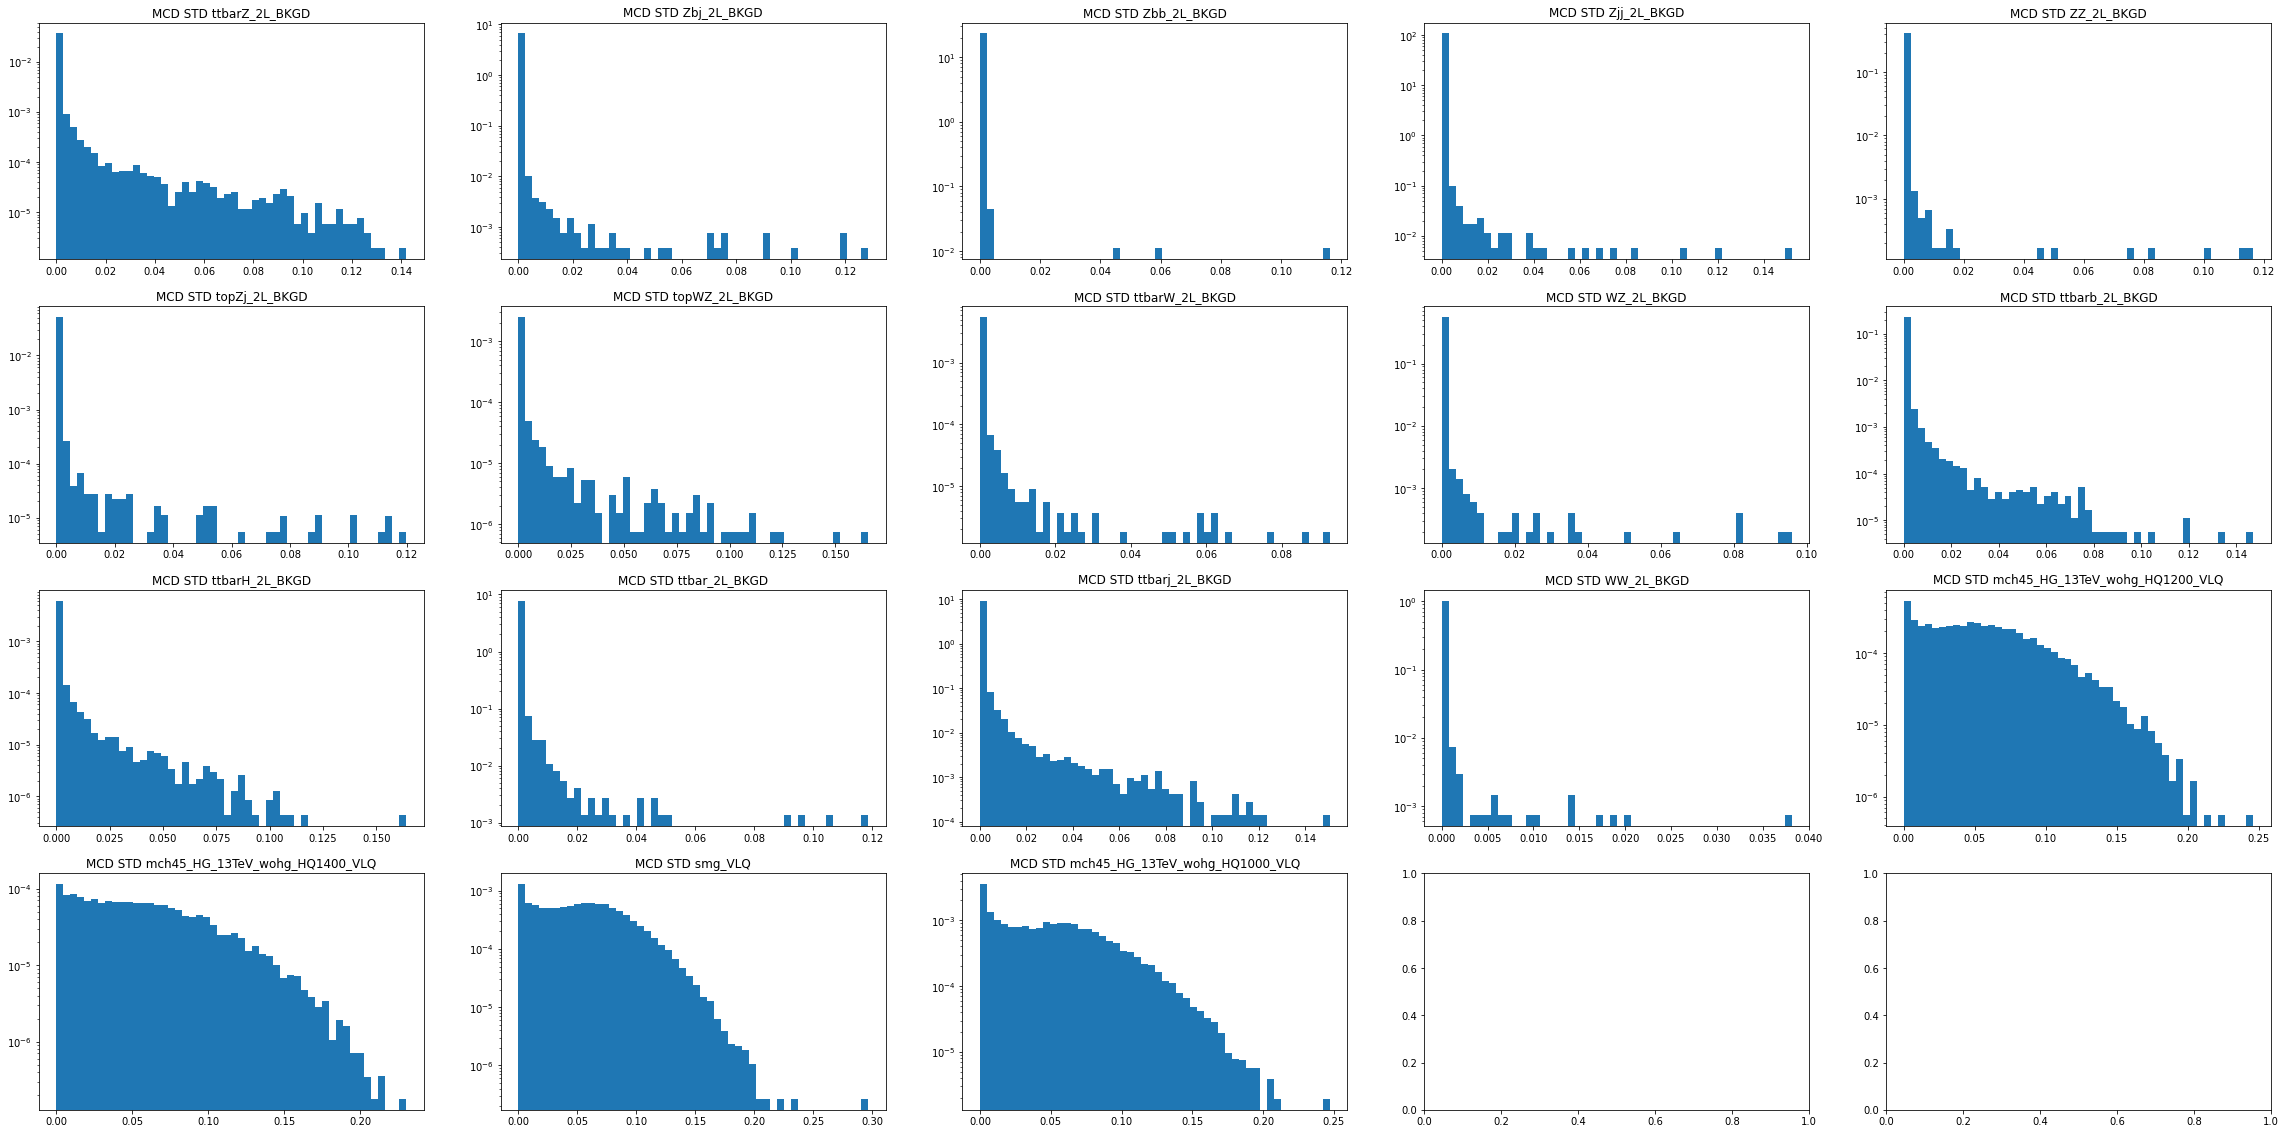

In [27]:
# Plot adjustment variables
num_cols, bins = 5, 50

# Generate the plots
num_rows = int(np.ceil((len(samples)) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 20))

# Iterate and generate each data
for i, sample in enumerate(samples):
    # Plot the data
    row, col = int(i/num_cols), i%num_cols
    axs[row, col].set_title("MCD STD " + sample)
    sample = sample.replace("_BKGD", "").replace("_VLQ", "")
    axs[row, col].hist(mc_stds[val_samples == sample], bins=50, weights=val_weights[val_samples == sample])
    axs[row, col].set_yscale("log")
    
plt.savefig("plots/stds_distribution_mcd_per_sample.png", dpi=200)
plt.show()

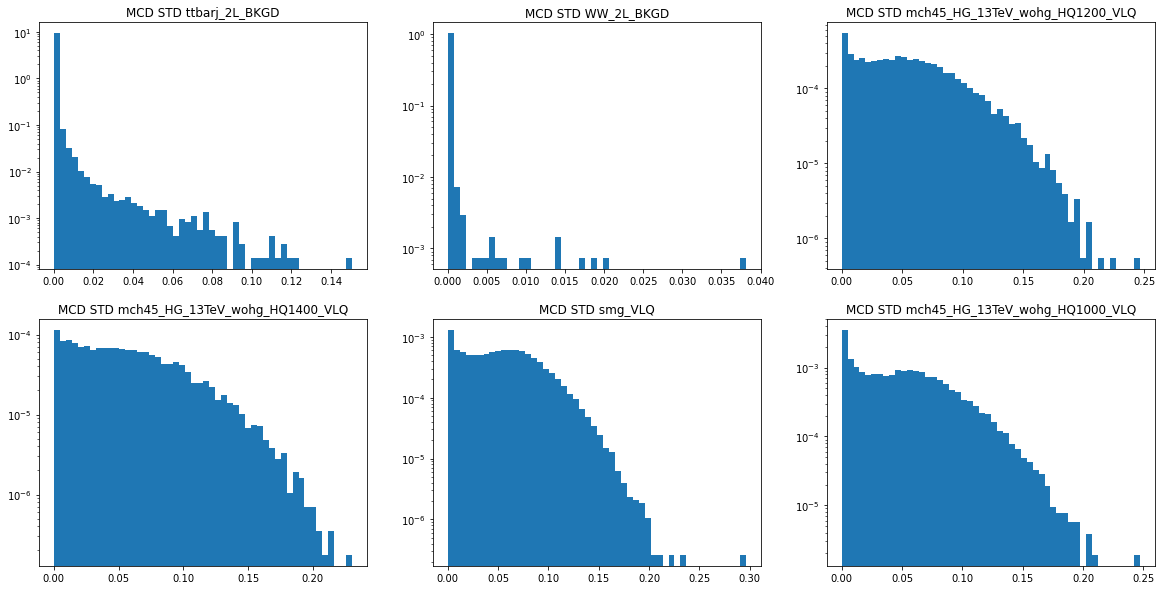

In [28]:
# Plot adjustment variables
bins = 50

# Generate the plots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Iterate and generate each data
for i, sample in enumerate(samples[12::]):
    row, col = i//3, i%3
    axs[row, col].set_title("MCD STD " + sample)
    sample = sample.replace("_BKGD", "").replace("_VLQ", "")
    axs[row, col].hist(mc_stds[val_samples == sample], bins=50, weights=val_weights[val_samples == sample])
    axs[row, col].set_yscale("log")
    
plt.savefig("plots/stds_distribution_mcd__sample.png", dpi=200)
plt.show()

# Std vs Means plot

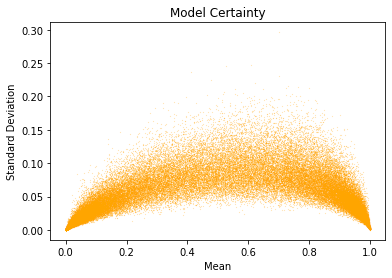

In [29]:
plt.title("Model Certainty")
plt.scatter(mc_means, mc_stds, s=0.01, color='orange')
plt.ylabel("Standard Deviation")
plt.xlabel("Mean")
plt.show()